In [1]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
import os

In [2]:
data_dir = "old-mic-data"

right_200m_1_path = os.path.join(data_dir, "200m-right-1.wav")
left_200m_1_path = os.path.join(data_dir, "200m-left-1.wav")

# Assuming same sample rate for both files
right_200m_1, sr_right = librosa.load(right_200m_1_path, sr=None)
left_200m_1, sr_left = librosa.load(left_200m_1_path, sr=None)

assert sr_right == sr_left

sr = sr_right

print(f"Right audio shape: {right_200m_1.shape}")
print(f"Left audio shape: {left_200m_1.shape}")
print(f"Sample rates - Right: {sr_right}, Left: {sr_left}")

Right audio shape: (464896,)
Left audio shape: (472064,)
Sample rates - Right: 48000, Left: 48000


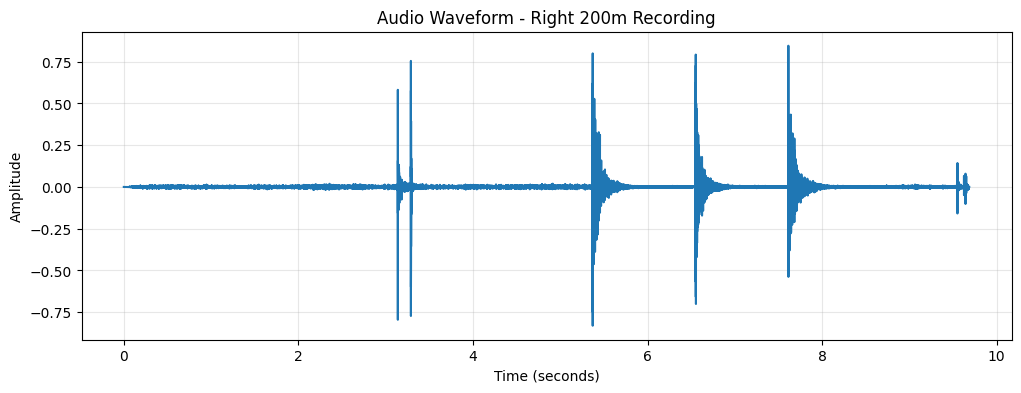

In [3]:
# Create time axis for plotting
time = np.linspace(0, len(right_200m_1) / sr_right, len(right_200m_1))

# Plot the waveform
plt.figure(figsize=(12, 4))
plt.plot(time, right_200m_1)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Audio Waveform - Right 200m Recording')
plt.grid(True, alpha=0.3)
plt.show()

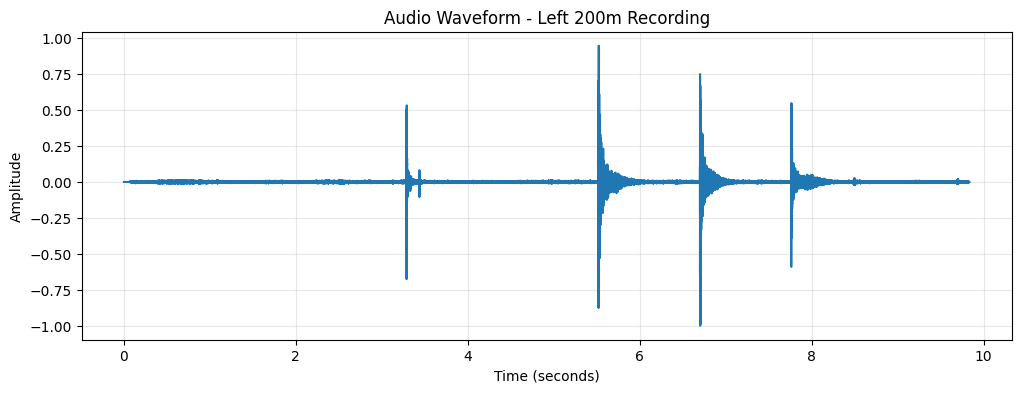

In [4]:
# Create time axis for plotting
time = np.linspace(0, len(left_200m_1) / sr_left, len(left_200m_1))

# Plot the waveform
plt.figure(figsize=(12, 4))
plt.plot(time, left_200m_1)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Audio Waveform - Left 200m Recording')
plt.grid(True, alpha=0.3)
plt.show()

In [5]:
init_impulse_window = 400_000
right_init_impulse = right_200m_1[:init_impulse_window]
left_init_impulse = left_200m_1[:init_impulse_window]

In [6]:
time_init_impulse = np.linspace(0, init_impulse_window / sr, init_impulse_window)

/var/folders/j0/1mnwzd6d5sq2mts6vb73_93h0000gn/T/ipykernel_13131/3179781672.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


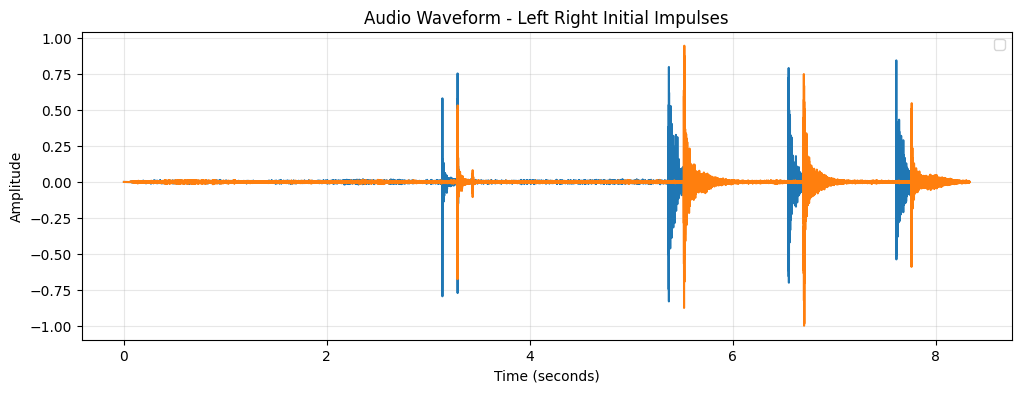

In [7]:
# Plot the waveform
plt.figure(figsize=(12, 4))
plt.plot(time_init_impulse, right_init_impulse)
plt.plot(time_init_impulse, left_init_impulse)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Audio Waveform - Left Right Initial Impulses')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [8]:
def gcc_phat(sig, refsig, fs=1, max_tau=None, interp=16):
    """
    Compute the time delay estimate between sig and refsig using GCC-PHAT.

    Args:
        sig (ndarray): Signal 1.
        refsig (ndarray): Signal 2 (reference).
        fs (int, optional): Sampling frequency (Hz). Default=1.
        max_tau (float, optional): Maximum delay (seconds) to search for.
        interp (int, optional): Interpolation factor for finer resolution.

    Returns:
        float: Estimated delay (in seconds).
        ndarray: Cross-correlation function.
    """

    n = sig.shape[0] + refsig.shape[0]

    # FFT of both signals
    SIG = np.fft.rfft(sig, n=n)
    REFSIG = np.fft.rfft(refsig, n=n)

    # Cross-spectral density
    R = SIG * np.conj(REFSIG)

    # Apply PHAT weighting
    R /= np.abs(R) + np.finfo(float).eps

    # Inverse FFT to get cross-correlation
    cc = np.fft.irfft(R, n=interp*n)

    max_shift = int(interp * n / 2)
    if max_tau:
        max_shift = np.minimum(int(interp*fs*max_tau), max_shift)

    cc = np.concatenate((cc[-max_shift:], cc[:max_shift+1]))

    # Find shift index
    shift = np.argmax(np.abs(cc)) - max_shift

    tau = shift / float(interp * fs)

    return tau, cc

In [9]:
# # load both (resample to same fs optionally)
# fs_l, left = sr, np.append(np.zeros(sr), right_200m_1)
# fs_r, right = sr, right_200m_1
# if fs_l != fs_r:
#     raise ValueError("sample rates differ even after resampling: %d vs %d" % (fs_l, fs_r))
# fs = fs_l

# # optional DC removal / high-pass to reduce low-frequency drift (simple)
# left = left - np.mean(left)
# right = right - np.mean(right)

# # run GCC-PHAT. Convention: tau > 0 => left is AFTER right => right closer
# tau, cc, lags = gcc_phat(left, right, fs=fs, max_tau=None, interp=16)

# delta_distance = tau * 343  # meters

# print("=== GCC-PHAT TDOA result ===")
# print(f"sample rate: {fs} Hz")
# print(f"estimated time delay (tau): {tau:.6f} s")
# print(f"estimated distance difference (Δd = c * tau): {delta_distance:.4f} m")
# # Interpret sign:
# if tau > 0:
#     print("Interpretation: LEFT signal arrives later than RIGHT → RIGHT is closer by ≈ {:.4f} m".format(abs(delta_distance)))
# elif tau < 0:
#     print("Interpretation: LEFT signal arrives earlier than RIGHT → LEFT is closer by ≈ {:.4f} m".format(abs(delta_distance)))
# else:
#     print("Signals appear simultaneous (τ ≈ 0).")
# # tau, delta_distance, cc, lags

fs = sr

tau, cc = gcc_phat(left_200m_1, right_200m_1, fs=fs, max_tau=0.1)
speed_of_sound = 343

print(f"Estimated delay = {tau:.6f} s, distance = {tau * speed_of_sound:.2f} m")



Estimated delay = 0.081465 s, distance = 27.94 m


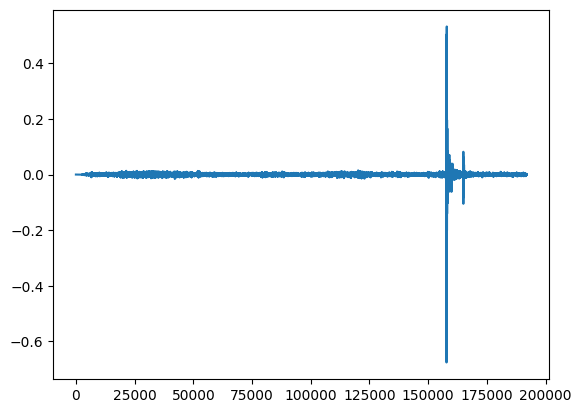

In [10]:
plt.plot(left_200m_1[:4*fs])

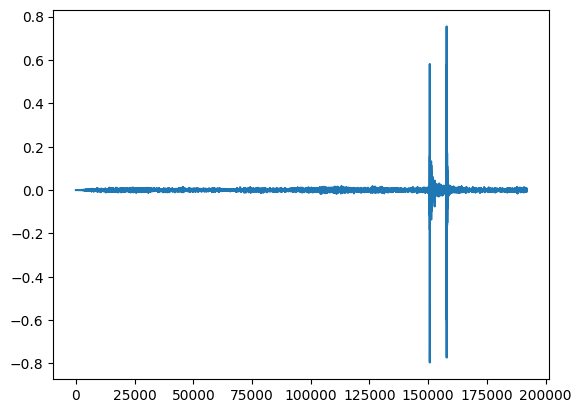

In [11]:
plt.plot(right_200m_1[:4*fs])

In [ ]:
legacy = "../test_assets/legacy/gunshot.wav"

legacy_audio, legacy_sr = librosa.load(legacy, sr=None)


gunshot_positions = {
    "mic_1_origin": {
        "mic_1": legacy_audio,
        "mic_2": np.append(np.zeros(int(0.003010 * legacy_sr)), legacy_audio),
        "mic_3": np.append(np.zeros(int(0.001644 * legacy_sr)), legacy_audio)
    },
    "mic_2_origin": {
        "mic_1": np.append(np.zeros(int(0.003086 * legacy_sr)), legacy_audio),
        "mic_2": legacy_audio,
        "mic_3": np.append(np.zeros(int(0.001644 * legacy_sr)), legacy_audio)
    },
    "mic_3_origin": {
        "mic_1": np.append(np.zeros(int(0.002602 * legacy_sr)), legacy_audio),
        "mic_2": np.append(np.zeros(int(0.002602 * legacy_sr)), legacy_audio),
        "mic_3": legacy_audio
    }
}

for position, gunshot_position in gunshot_positions.items():
    for mic, gunshot_samples in gunshot_position.items():
        os.makedirs(f"../test_assets_v2/{position}", exist_ok=True)
        sf.write(f"../test_assets_v2/{position}/{mic}.wav", gunshot_samples, legacy_sr)

TypeError: expected a sequence of integers or a single integer, got '144.48000000000002'